Procesando: glioma (63).jpg


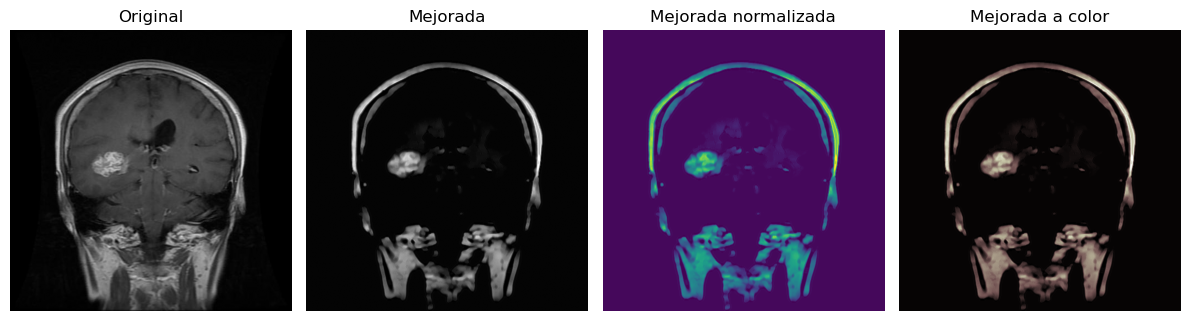

Área del tumor: 236445 píxeles
PSNR: 30.44 dB
SSIM: 0.5062
Procesamiento finalizado para: glioma (63).jpg


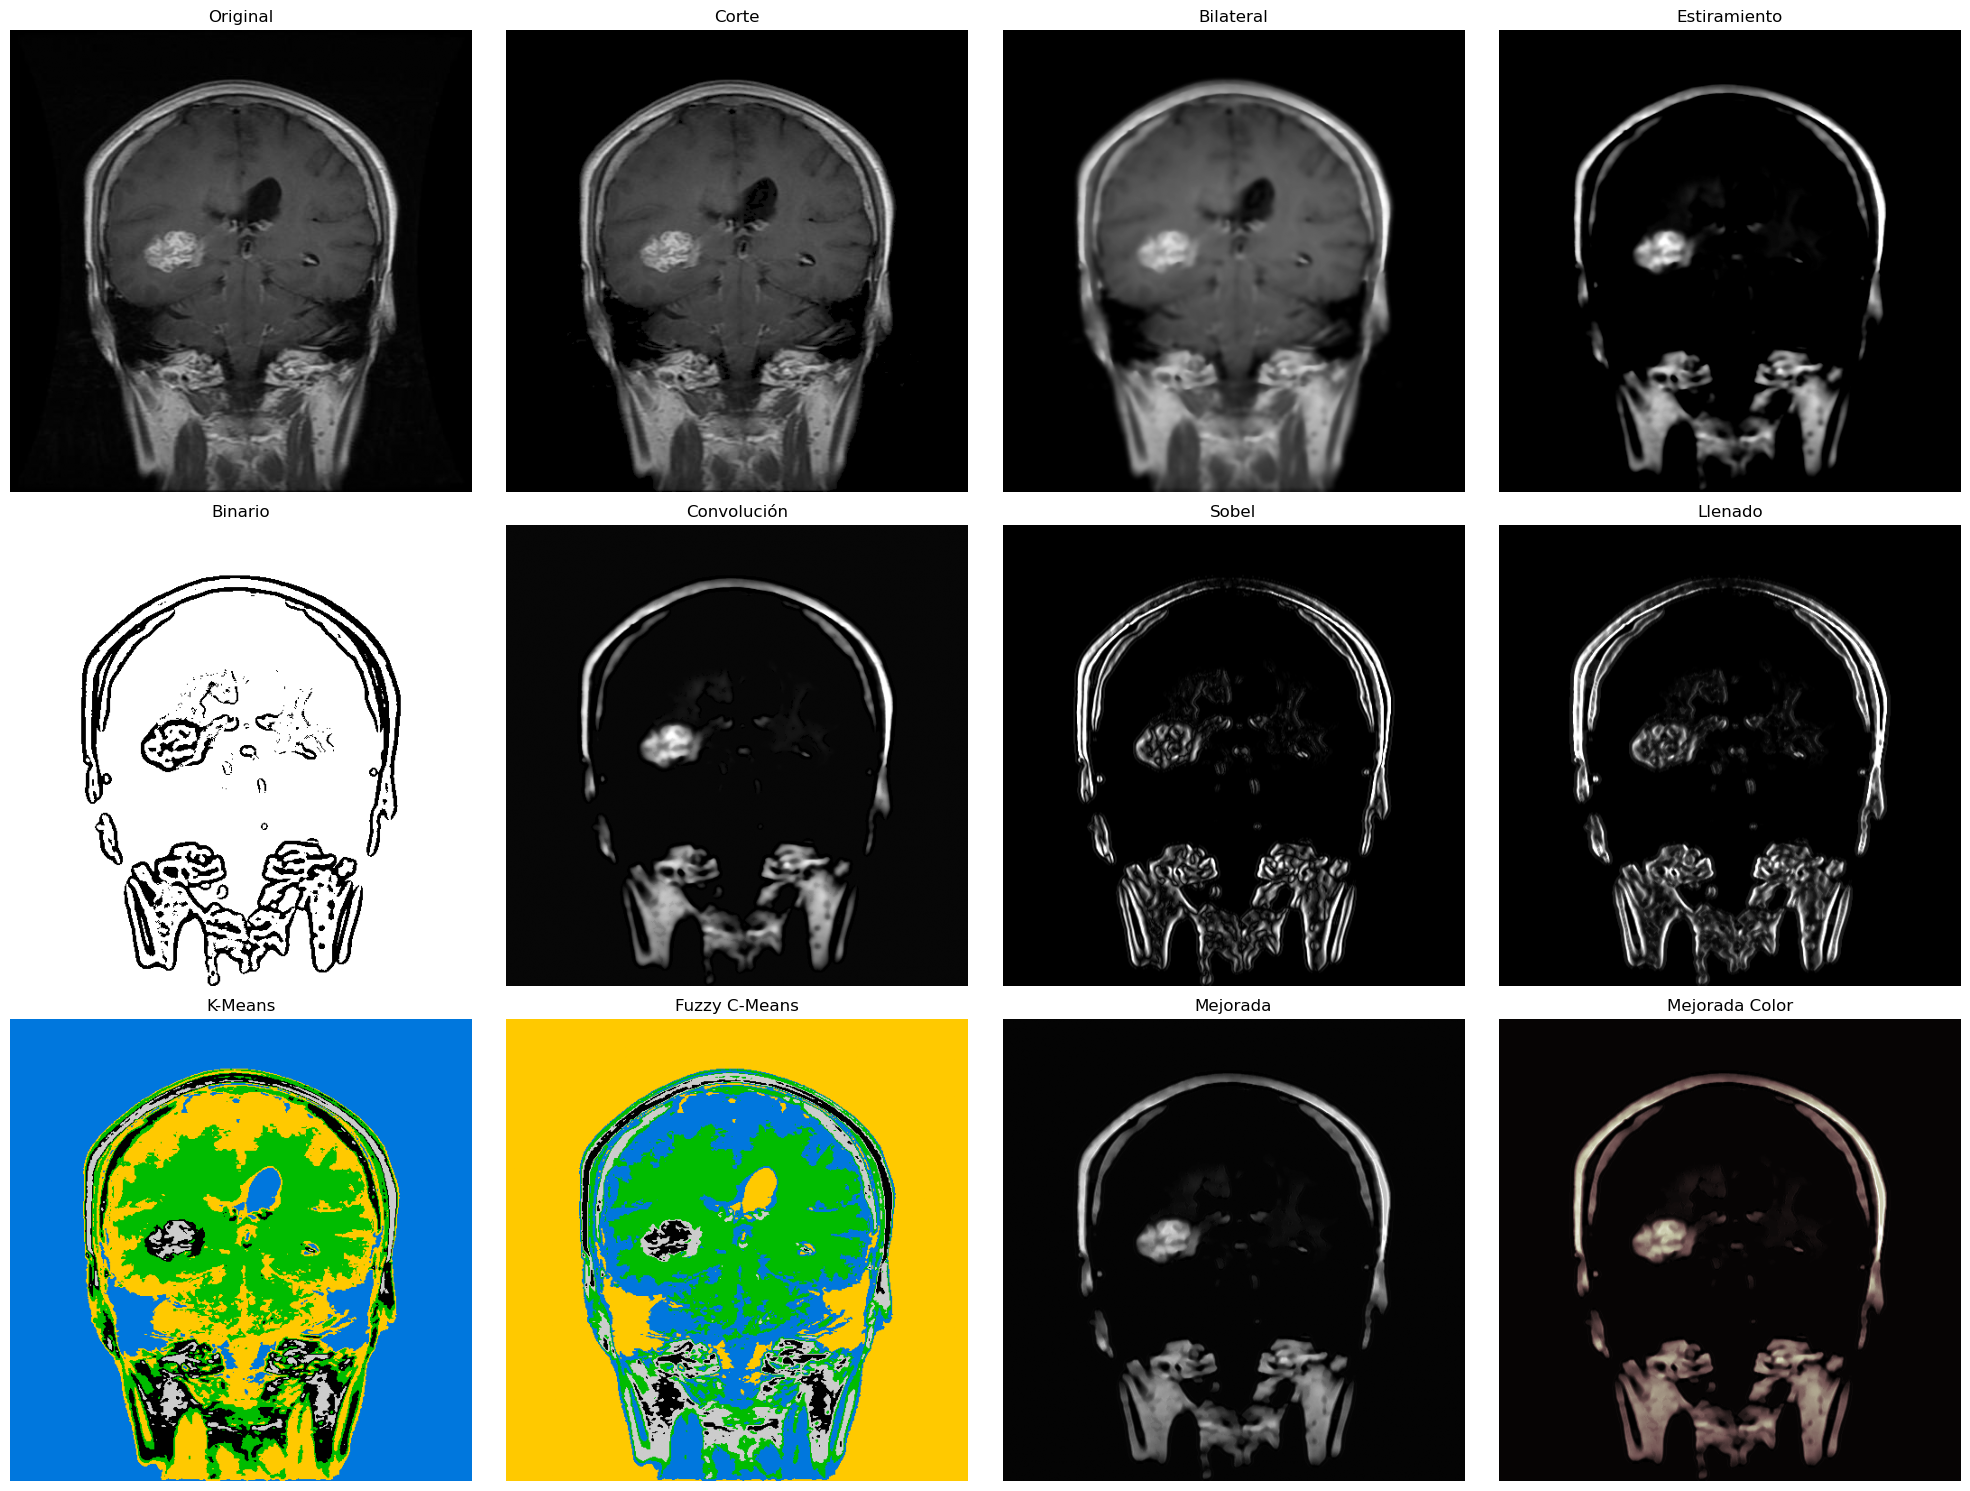

Procesamiento completo. Resultados guardados en: resultados_procesamiento


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim  # Para calcular SSIM (Structural Similarity Index)
from skfuzzy import cmeans  # Para clustering Fuzzy C-Means

# Directorios de entrada y salida para las imágenes a procesar y los resultados respectivamente
input_dir = 'imagenes_entrada'
output_dir = 'resultados_procesamiento'
os.makedirs(output_dir, exist_ok=True)  # Crear directorio de salida si no existe

# Parámetros configurables
THRESHOLD_VALUE = 15  # Umbral para corte del fondo
BILATERAL_PARAMS = {'d': 9, 'sigmaColor': 70, 'sigmaSpace': 70}  # Parámetros del filtro bilateral
GRAY_LEVEL_RANGE = {'low': 0.3, 'high': 0.7}  # Rango de contraste para estiramiento
KERNEL_SIZE = 3  # Tamaño del kernel para operaciones morfológicas
CLUSTERS = 5  # Número de clusters para K-Means y Fuzzy C-Means

# Función para calcular PSNR
def calculate_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Función para calcular SSIM
def calculate_ssim(original, processed):
    score, _ = ssim(original, processed, full=True)
    return score

# Función para estiramiento del nivel de gris al rango [0, 1]
def gray_level_stretching(image, low=0.2, high=0.8):
    stretched = np.clip((image / 255 - low) / (high - low), 0, 1)
    return np.uint8(stretched * 255)

# Función para corte automático del fondo basado en umbral
def cut_background(image, threshold=10):
    _, mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return cv2.bitwise_and(image, image, mask=mask)

# Crear un elemento estructural circular para operaciones morfológicas
def create_kernel(size=6):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

# Función para aplicar Fuzzy C-Means
def apply_fuzzy_c_means(image, clusters=6):
    flat_image = image.flatten().astype(np.float64)
    cntr, u, _, _, _, _, _ = cmeans(flat_image.reshape(1, -1), c=clusters, m=2, error=0.005, maxiter=1000)
    fuzzy_segmented = np.argmax(u, axis=0).reshape(image.shape)
    return fuzzy_segmented

# Función principal de procesamiento
def process_image(image, img_name):
    print(f"Procesando: {img_name}")

    # Paso 0: Corte automático del fondo
    cut_image = cut_background(image, threshold=THRESHOLD_VALUE)

    # Paso 1: Reducción de ruido con filtro bilateral
    bilateral = cv2.bilateralFilter(cut_image, **BILATERAL_PARAMS)

    # Paso 2: Mejora de contraste con estiramiento del nivel de gris
    stretched = gray_level_stretching(bilateral, **GRAY_LEVEL_RANGE)

    # Paso 3: Operaciones morfológicas
    kernel = create_kernel(size=KERNEL_SIZE)
    binary = cv2.adaptiveThreshold(stretched, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    eroded = cv2.erode(binary, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    # Paso 4: Convolución
    convolved = np.uint8(dilated * 0.03 + stretched * 0.97)

    # Paso 5: Detección de bordes con Sobel y llenado
    sobel = cv2.Sobel(convolved, cv2.CV_64F, 1, 0, ksize=3)
    sobel = cv2.convertScaleAbs(sobel)
    filled = cv2.morphologyEx(sobel, cv2.MORPH_CLOSE, kernel)

    # Paso 6: Clustering K-Means
    Z = image.reshape((-1, 1)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, CLUSTERS, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    clustered = labels.reshape(image.shape)

    # Paso 7: Fuzzy C-Means
    fuzzy_segmented = apply_fuzzy_c_means(image, clusters=CLUSTERS)

    # Cálculo del área del tumor
    tumor_area = cv2.countNonZero(binary)

    # Combinación de las imágenes
    improved_image = np.uint8(0.5 * convolved + 0.25 * clustered + 0.25 * fuzzy_segmented + 0.15 * filled)
    improved_image_normalized = cv2.normalize(improved_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    improved_color = cv2.applyColorMap(improved_image_normalized, cv2.COLORMAP_BONE) # Aplicar mapa de colores  

    # Métricas de calidad
    psnr_value = calculate_psnr(image, improved_image_normalized)
    ssim_value = calculate_ssim(image, improved_image_normalized)    

    # Guardar resultados
    base_name = os.path.splitext(img_name)[0]
    result_dir = os.path.join(output_dir, base_name)
    os.makedirs(result_dir, exist_ok=True)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_original.png"), image)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_cut.png"), cut_image)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_bilateral.png"), bilateral)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_stretched.png"), stretched)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_binary.png"), binary)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_convolved.png"), convolved)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_sobel.png"), sobel)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_filled.png"), filled)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_clustered.png"), clustered)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_fuzzy_segmented.png"), fuzzy_segmented)
    cv2.imwrite(os.path.join(result_dir, f"{base_name}_final.png"), improved_color)

    # Visualización comparativa
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    axs[0].imshow(image, cmap='gray'); axs[0].set_title("Original")
    axs[1].imshow(improved_image, cmap='gray'); axs[1].set_title("Mejorada")
    axs[2].imshow(improved_image_normalized); axs[2].set_title("Mejorada normalizada")
    axs[3].imshow(improved_color); axs[3].set_title("Mejorada a color")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(result_dir, f"{base_name}_comparacion_mejoras.png"), dpi=300)
    plt.show()

    print(f"Área del tumor: {tumor_area} píxeles")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"Procesamiento finalizado para: {img_name}")

    # Mostrar una matriz de imágenes generadas por orden
    fig, axs = plt.subplots(3, 4, figsize=(20, 15))
    axs[0, 0].imshow(image, cmap='gray'); axs[0, 0].set_title("Original")
    axs[0, 1].imshow(cut_image, cmap='gray'); axs[0, 1].set_title("Corte")
    axs[0, 2].imshow(bilateral, cmap='gray'); axs[0, 2].set_title("Bilateral")
    axs[0, 3].imshow(stretched, cmap='gray'); axs[0, 3].set_title("Estiramiento")
    axs[1, 0].imshow(binary, cmap='gray'); axs[1, 0].set_title("Binario")
    axs[1, 1].imshow(convolved, cmap='gray'); axs[1, 1].set_title("Convolución")
    axs[1, 2].imshow(sobel, cmap='gray'); axs[1, 2].set_title("Sobel")
    axs[1, 3].imshow(filled, cmap='gray'); axs[1, 3].set_title("Llenado")
    axs[2, 0].imshow(clustered, cmap='nipy_spectral'); axs[2, 0].set_title("K-Means")
    axs[2, 1].imshow(fuzzy_segmented, cmap='nipy_spectral'); axs[2, 1].set_title("Fuzzy C-Means")
    axs[2, 2].imshow(improved_image, cmap='gray'); axs[2, 2].set_title("Mejorada")
    axs[2, 3].imshow(improved_color); axs[2, 3].set_title("Mejorada Color")
    for ax in axs.flat: ax.axis('off')
    plt.tight_layout()
    plt.show()

# Procesar todas las imágenes
imagenes = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
for img_name in imagenes:
    img_path = os.path.join(input_dir, img_name)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        process_image(image, img_name)

print("Procesamiento completo. Resultados guardados en:", output_dir)

